### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use("ggplot")
np.random.seed(0)

In [2]:
import tensorflow as tf
print('tensorflow version:',tf.__version__)
print('GPU detected:',tf.config.list_physical_devices('GPU'))
print('CPU detected:',tf.config.list_physical_devices('CPU'))

tensorflow version: 2.4.1
GPU detected: []
CPU detected: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### Task2: Load and Explore the NER Dataset

In [3]:
#load train data
stock_files={}
j = 0
j_file={}
#for i in range (2142,32278300,1):
for i in range (2142,12278300,1):
    try:
        files = open('D:/2021spring/text mining and deep learning/homework/train/train/'+str(i)+'.bio.txt')
        stock_files[j] = files.readlines()
        j_file[j]=i
        files.close()
        j +=1
    except:
        continue

In [4]:
# load text file
test_files={}
j = 0
#for i in range (206933,32277300,1):
for i in range (206933,12277300,1):
    try:
        files = open('D:/2021spring/text mining and deep learning/homework/test/test/'+str(i)+'.bio.txt')
        test_files[j] = files.readlines()
        j +=1
        files.close()
    except:
        continue

### Task 3: Retrieve Sentences and Corresponsing Tags

In [5]:
words = set()
tags = set()
data = []
file_data =[]
for i in range(len(stock_files)):
    file = stock_files[i]
    sentence = []
    number_file = j_file[i]
    for line in file:
        #line = line.strip() #there are some space as a word
        line=line.split('\n') # tags have a '\n' 
        line = line[0]
        line=line.split('\t')
        if len(line)>1:
            words.add(line[0])
            tag = line[4]            
            tags.add(tag)
            s= (line[0],tag)
            sentence.append(s)
        else:
            data.append(sentence)
            s_n = (sentence,number_file)
            file_data.append(s_n)
            sentence = []

In [6]:
test_data = []
for i in range(len((test_files.keys()))):
    file = test_files[i]
    sentence = []
    for line in file:
        #line = line.strip() #there are some space as a word
        line=line.split('\n') # tags have a '\n' 
        line = line[0]
        line=line.split('\t')
        if len(line)>1:
            words.add(line[0])
            s = line[0]
            sentence.append(s)
        else:
            test_data.append(sentence)
            sentence = []

In [7]:
words=list(words)
num_words=len(words)
tags=list(tags)
num_tags = len(tags)

### Task4: Define Mappints between Sentences and Tags

In [8]:
word2idx = {w: i for i , w in enumerate(words)}
tag2idx = {t : i for i , t in enumerate(tags)}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

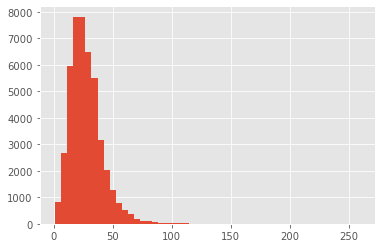

In [9]:
plt.hist([len(s) for s in data],bins = 50)
plt.show()

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [11]:
max_len = 80

In [12]:
# word index
X = [[word2idx[w[0]] for w in s ] for s in data]
X = pad_sequences(maxlen=max_len,sequences = X,padding='post',value= num_words-1)

y = [[tag2idx[w[1]] for w in s ] for s in data]
y = pad_sequences(maxlen=max_len,sequences = y,padding='post',value= tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

test = [[word2idx[w] for w in s ] for s in test_data]
test = pad_sequences(maxlen=max_len,sequences = test,padding='post',value= num_words-1)

In [13]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [14]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed,SpatialDropout1D,Bidirectional

In [15]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim = num_words,output_dim = max_len,input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags, activation = 'softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 80, 80)            4043600   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 80, 80)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 200)           144800    
_________________________________________________________________
time_distributed (TimeDistri (None, 80, 15)            3015      
Total params: 4,191,415
Trainable params: 4,191,415
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',
             loss = 'categorical_crossentropy',
              metrics = ['accuracy']
             )

### Task7: Train the Model

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

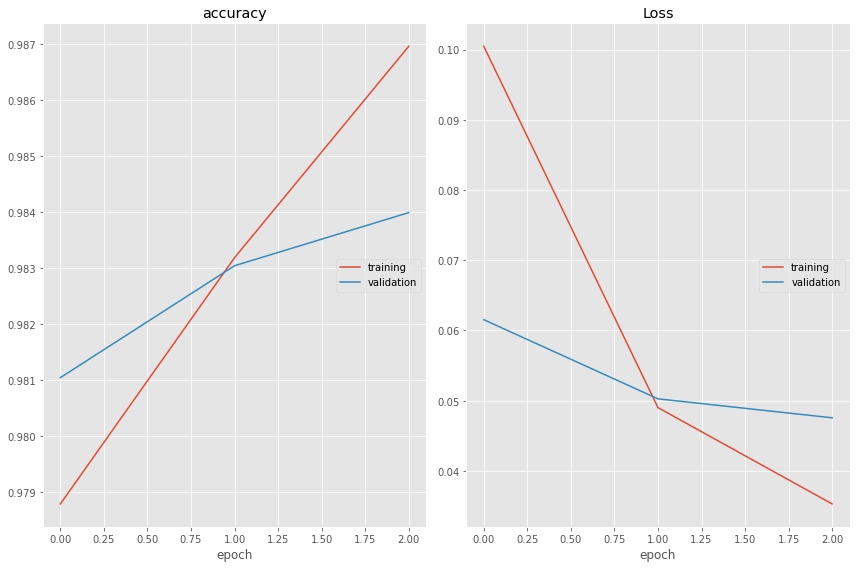

accuracy
	training         	 (min:    0.979, max:    0.987, cur:    0.987)
	validation       	 (min:    0.981, max:    0.984, cur:    0.984)
Loss
	training         	 (min:    0.035, max:    0.100, cur:    0.035)
	validation       	 (min:    0.048, max:    0.062, cur:    0.048)


In [18]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',patience = 1,verbose = 0,mode='max',restore_best_weights= False)
callbacks = [PlotLossesCallback(),early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 16,
    epochs = 3,
    verbose=1,
    callbacks = callbacks
)

### Task 8: Evaluate Named Entity Recognition Model

In [19]:
i = np.random.randint(0,x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p,axis = -1)

y_true = np.argmax(np.array(y_test),axis=-1)[i]
print("{:25}{:15}\t{}\n".format("Word","True","Pred"))
print("-"*50)
for w, true,pred in zip(x_test[i],y_true,p[0]):
    print("{:25}{:15}\t{}\n".format(words[w],tags[true],tags[pred]))

Word                     True           	Pred

--------------------------------------------------
It                       O              	O

was                      O              	O

not                      O              	O

possible                 O              	O

to                       O              	O

meet                     O              	O

the                      O              	O

recommended              O              	O

tolerance                O              	O

limits                   O              	O

of                       O              	O

the                      O              	O

redundancy               O              	O

checks                   O              	O

without                  O              	O

taking                   O              	O

into                     O              	O

account                  O              	O

the                      O              	O

angular                  O              	O

response              

In [20]:
pairs = {}
dif_class_word = {}

for s in file_data:
    for pair in s[0]:
        if pair[0] not in list(pairs.keys()):            
            pairs[pair[0]]=pair[1]
        else:
            if pairs[pair[0]]!=pair[1]:
                #print(pair[0])
                dif_class_word[pair[0]]=pair[1]
            else:
                continue
                

In [21]:
w_ = []
for s in file_data:
    for pair in s[0]:
            if pair[0]==':':
                pair_ =(pair,s[1])
                w_.append(pair_)
            else:
                continue

In [22]:
total=0
correct = 0
wrong = 0
correct_words=[]
wrong_words=[]
wrong_in_train = 0
correct_not_in = 0
for i in range(len(x_test)):
    p = model.predict(np.array([x_test[i]]))
    p = np.argmax(p,axis = -1)

    y_true = np.argmax(np.array(y_test),axis=-1)[i]
    for w, true,pred in zip(x_test[i],y_true,p[0]):
        if words[w]=='mediolateral':
            continue
        elif tags[true]==tags[pred]:
            correct+=1
            total+=1
            correct_words.append(words[w])
            if w not in x_train:
                correct_not_in +=1
        else:
            wrong +=1
            total+=1
            wrong_words.append(words[w])
            if w in x_train:
                wrong_in_train +=1


In [28]:
Y_true = []
Y_pred = []
X_w = []
for i in range(len(x_test)):
    p = model.predict(np.array([x_test[i]]))
    p = np.argmax(p,axis = -1)
    y_true = np.argmax(np.array(y_test),axis=-1)[i]
    for w, true,pred in zip(x_test[i],y_true,p[0]):
        Y_true.append(true)
        Y_pred.append(pred)
        X_w.append(w)


In [27]:
from sklearn.metrics import f1_score

In [249]:
F1 = f1_score(Y_true,Y_pred,average='macro')

In [248]:
print(F1)

0.9835327627562146


In [63]:
tag2 = {}
for t in tag2idx:
    tag2[tag2idx[t]] = t
 

In [131]:
tag_pre = {}
tag_p = []
for tag in tags:
    if tag=='O':
        continue
    else:
        
        for i in range(len(Y_true)):
            tag_w = Y_true[i]
            if tag2[tag_w]==tag:
                pre_w = Y_pred[i]            
                tag_p.append(tag2[pre_w])
    tag_pre[tag]=tag_p
    tag_p = []
            
            
    

In [132]:
from collections import Counter

In [186]:
keys = list(tag_pre.keys())
keys.sort()
m = len(keys)
result = np.zeros((m,m),dtype='int')

In [187]:
tags.sort(reverse=true)
for i in range(m):
    w = keys[i]
    r = tag_pre[w]
    counter = Counter(r)
    for j in range(m):
        n = counter[keys[j]]
        result[i,j]=int(n)
        

In [152]:
import seaborn as sns
import pandas as pd
import numpy as np

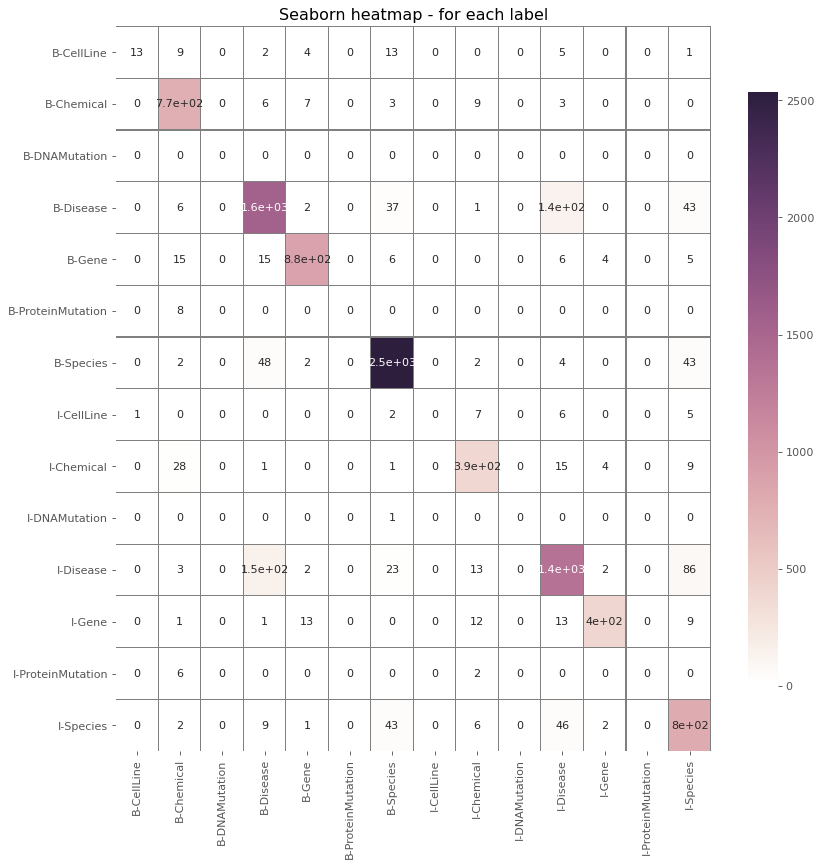

In [244]:
df = pd.DataFrame(result,columns=keys,index=keys,dtype='int')
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
res = sns.heatmap(df, annot=True,cmap=cmap, cbar_kws={"shrink": .82},
                  linewidths=0.1, linecolor='gray')
plt.title('Seaborn heatmap - for each label')

plt.savefig('seaborn_heatmap_ticklabels_font_size_04.png')              
plt.show()


In [240]:
precision = {}
recall = {}
F1 = {}
for i in range(m):
    if sum(result[:,i])==0:
        precision[keys[i]]='NA'
    else:
        preci = result[i,i]/sum(result[:,i])
        precision[keys[i]] = preci     

    if sum(result[i,:])==0:
        recall[keys[i]] ='NA'
    else: 
        rec = result[i,i]/sum(result[i,:])
        recall[keys[i]] = rec
    F = 2*preci*rec/(preci+rec)
    F1[keys[i]]=F

In [241]:
for s in precision:
    print(s,precision[s])

B-CellLine 0.9285714285714286
B-Chemical 0.9059929494712103
B-DNAMutation NA
B-Disease 0.8685682326621924
B-Gene 0.9661572052401747
B-ProteinMutation NA
B-Species 0.9516129032258065
I-CellLine NA
I-Chemical 0.8831460674157303
I-DNAMutation NA
I-Disease 0.8542183622828784
I-Gene 0.9710843373493976
I-ProteinMutation NA
I-Species 0.7981927710843374


In [242]:
for r in recall:
    print(r,recall[r])

B-CellLine 0.2765957446808511
B-Chemical 0.9649561952440551
B-DNAMutation NA
B-Disease 0.8729623383923553
B-Gene 0.9455128205128205
B-ProteinMutation 0.0
B-Species 0.9617134192570129
I-CellLine 0.0
I-Chemical 0.8713968957871396
I-DNAMutation 0.0
I-Disease 0.8300180831826401
I-Gene 0.8915929203539823
I-ProteinMutation 0.0
I-Species 0.879424778761062


In [243]:
for f in F1:
    print(f,F1[f])

B-CellLine 0.42622950819672134
B-Chemical 0.9345454545454545
B-DNAMutation 0.9345454545454545
B-Disease 0.8707597420801794
B-Gene 0.9557235421166306
B-ProteinMutation 0.0
B-Species 0.9566365007541479
I-CellLine 0.0
I-Chemical 0.8772321428571428
I-DNAMutation 0.0
I-Disease 0.8419443595230816
I-Gene 0.9296424452133795
I-ProteinMutation 0.0
I-Species 0.8368421052631579


In [245]:
outfile = open('D:/2021spring/text mining and deep learning/homework/test.txt',mode='w',newline='\n')

In [246]:
for i in range(len(test)):
    test_pre = model.predict(np.array([test[i]]))
    test_pre = np.argmax(test_pre,axis = -1)

    for w,pred in zip(test[i],test_pre[0]):
        if words[w]=='tracheitis':
            continue
        else:
            outfile.write(words[w]+' '+tags[pred] + '\n')